[itsandrewgao](https://twitter.com/itsandrewgao) my very rushed and shitty attempt at implementing just the mLSTM to predict sine waves

<a target="_blank" href="https://colab.research.google.com/github/andrewgcodes/xlstm/blob/main/mLSTM.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss 90129.875
Epoch 10 Loss 80800.5625
Epoch 20 Loss 73513.6484375
Epoch 30 Loss 67557.3359375
Epoch 40 Loss 62003.3984375
Epoch 50 Loss 55869.328125
Epoch 60 Loss 49559.55078125
Epoch 70 Loss 42777.39453125
Epoch 80 Loss 36549.33203125
Epoch 90 Loss 31875.568359375
Epoch 100 Loss 27474.734375
Epoch 110 Loss 22721.779296875
Epoch 120 Loss 18597.736328125
Epoch 130 Loss 15703.3466796875
Epoch 140 Loss 13845.51953125
Epoch 150 Loss 12651.5576171875
Epoch 160 Loss 11877.65625
Epoch 170 Loss 11347.5966796875
Epoch 180 Loss 10954.935546875
Epoch 190 Loss 10601.2890625


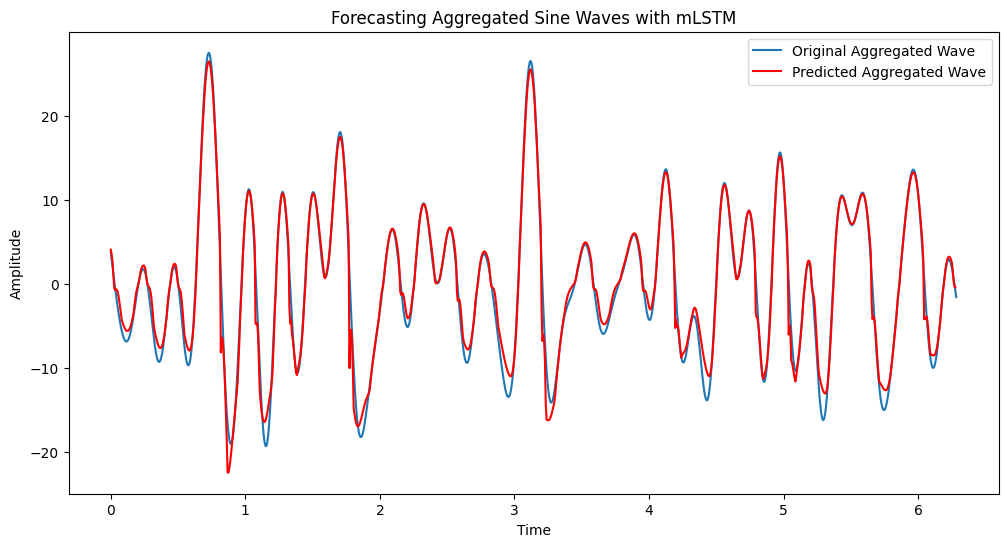

In [1]:
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt

# Function to generate individual sine waves
def generate_sine_wave(amplitude, frequency, phase, time):
    return amplitude * np.sin(2 * np.pi * frequency * time + phase)

# Generate aggregated sine wave
def generate_aggregated_wave(num_waves, time):
    aggregated_wave = np.zeros_like(time)
    for i in range(num_waves):
        amplitude = np.random.uniform(0.5, 2.0)  # Random amplitude between 0.5 and 2.0
        frequency = np.random.uniform(1, 5)     # Random frequency between 1 and 5 Hz
        phase = np.random.uniform(0, 2 * np.pi) # Random phase between 0 and 2*pi
        sine_wave = generate_sine_wave(amplitude, frequency, phase, time)
        aggregated_wave += sine_wave
    return aggregated_wave

# Define the mLSTM model
class mLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, mem_dim):
        super(mLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.mem_dim = mem_dim
        self.Wq = nn.Parameter(torch.randn(hidden_size, input_size))
        self.bq = nn.Parameter(torch.randn(hidden_size, 1))
        self.Wk = nn.Parameter(torch.randn(mem_dim, input_size))
        self.bk = nn.Parameter(torch.randn(mem_dim, 1))
        self.Wv = nn.Parameter(torch.randn(mem_dim, input_size))
        self.bv = nn.Parameter(torch.randn(mem_dim, 1))
        self.wi = nn.Parameter(torch.randn(1, input_size))
        self.bi = nn.Parameter(torch.randn(1))
        self.wf = nn.Parameter(torch.randn(1, input_size))
        self.bf = nn.Parameter(torch.randn(1))
        self.Wo = nn.Parameter(torch.randn(hidden_size, input_size))
        self.bo = nn.Parameter(torch.randn(hidden_size, 1))
        self.reset_parameters()

    def reset_parameters(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(self, x, states):
        (C_prev, n_prev) = states
        qt = torch.matmul(self.Wq, x) + self.bq
        kt = (1 / math.sqrt(self.mem_dim)) * (torch.matmul(self.Wk, x) + self.bk)
        vt = torch.matmul(self.Wv, x) + self.bv

        it = torch.exp(torch.matmul(self.wi, x) + self.bi)
        ft = torch.sigmoid(torch.matmul(self.wf, x) + self.bf)

        vt = vt.squeeze()
        kt = kt.squeeze()

        C = ft * C_prev + it * torch.ger(vt, kt)
        n = ft * n_prev + it * kt.unsqueeze(1)

        max_nqt = torch.max(torch.abs(torch.matmul(n.T, qt)), torch.tensor(1.0))
        h_tilde = torch.matmul(C, qt) / max_nqt
        ot = torch.sigmoid(torch.matmul(self.Wo, x) + self.bo)
        ht = ot * h_tilde

        return ht, (C, n)

    def init_hidden(self):
        return (torch.zeros(self.mem_dim, self.mem_dim),
                torch.zeros(self.mem_dim, 1))

# Hyperparameters
input_size = 1
hidden_size = 10
mem_dim = 10
seq_len = 1000
num_waves = 100

# Generate aggregated sine wave data
time = np.linspace(0, 2 * np.pi, seq_len)
aggregated_wave = generate_aggregated_wave(num_waves, time)
data = torch.tensor(aggregated_wave).float().view(1, -1, 1)

# Initialize the model, optimizer, and loss function
model = mLSTM(input_size, hidden_size, mem_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training the mLSTM
for epoch in range(200):
    states = model.init_hidden()
    optimizer.zero_grad()
    loss = 0
    for t in range(seq_len - 1):
        x = data[:, t]
        y_true = data[:, t + 1]
        y_pred, states = model(x, states)
        loss += criterion(y_pred, y_true)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss {loss.item()}')

# Testing the model
test_output = []
states = model.init_hidden()
for t in range(seq_len - 1):
    x = data[:, t]
    y_pred, states = model(x, states)
    test_output.append(y_pred.detach().numpy().ravel()[0])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time, aggregated_wave, label='Original Aggregated Wave')
plt.plot(time[:-1], test_output, label='Predicted Aggregated Wave', color='red')
plt.legend()
plt.title('Forecasting Aggregated Sine Waves with mLSTM')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


Epoch 0 Loss 784683.1875
Epoch 10 Loss 794590.625
Epoch 20 Loss 756582.5625
Epoch 30 Loss 712452.0
Epoch 40 Loss 665404.25
Epoch 50 Loss 626082.0625
Epoch 60 Loss 589579.0625
Epoch 70 Loss 574382.0
Epoch 80 Loss 557848.4375
Epoch 90 Loss 543798.5625
Epoch 100 Loss 534427.1875
Epoch 110 Loss 527558.25
Epoch 120 Loss 507148.90625
Epoch 130 Loss 475263.375
Epoch 140 Loss 447083.84375
Epoch 150 Loss 432756.46875
Epoch 160 Loss 422001.0625
Epoch 170 Loss 408559.65625
Epoch 180 Loss 385003.9375
Epoch 190 Loss 349863.28125


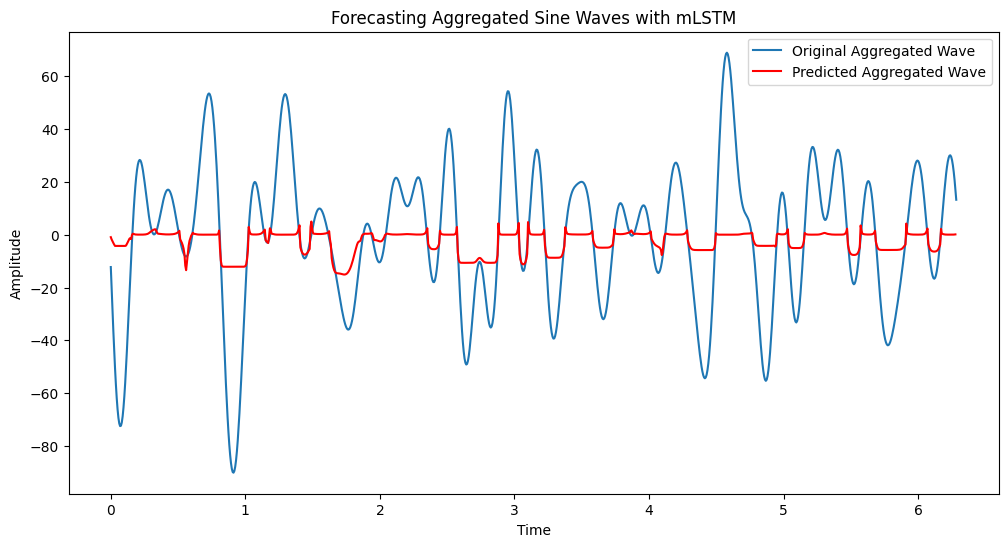

In [2]:
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt

# Function to generate individual sine waves
def generate_sine_wave(amplitude, frequency, phase, time):
    return amplitude * np.sin(2 * np.pi * frequency * time + phase)

# Generate aggregated sine wave
def generate_aggregated_wave(num_waves, time):
    aggregated_wave = np.zeros_like(time)
    for i in range(num_waves):
        amplitude = np.random.uniform(0.5, 2.0)  # Random amplitude between 0.5 and 2.0
        frequency = np.random.uniform(1, 5)     # Random frequency between 1 and 5 Hz
        phase = np.random.uniform(0, 2 * np.pi) # Random phase between 0 and 2*pi
        sine_wave = generate_sine_wave(amplitude, frequency, phase, time)
        aggregated_wave += sine_wave
    return aggregated_wave

# Define the mLSTM model
class mLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, mem_dim):
        super(mLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.mem_dim = mem_dim
        self.Wq = nn.Parameter(torch.randn(hidden_size, input_size))
        self.bq = nn.Parameter(torch.randn(hidden_size, 1))
        self.Wk = nn.Parameter(torch.randn(mem_dim, input_size))
        self.bk = nn.Parameter(torch.randn(mem_dim, 1))
        self.Wv = nn.Parameter(torch.randn(mem_dim, input_size))
        self.bv = nn.Parameter(torch.randn(mem_dim, 1))
        self.wi = nn.Parameter(torch.randn(1, input_size))
        self.bi = nn.Parameter(torch.randn(1))
        self.wf = nn.Parameter(torch.randn(1, input_size))
        self.bf = nn.Parameter(torch.randn(1))
        self.Wo = nn.Parameter(torch.randn(hidden_size, input_size))
        self.bo = nn.Parameter(torch.randn(hidden_size, 1))
        self.reset_parameters()

    def reset_parameters(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(self, x, states):
        (C_prev, n_prev) = states
        qt = torch.matmul(self.Wq, x) + self.bq
        kt = (1 / math.sqrt(self.mem_dim)) * (torch.matmul(self.Wk, x) + self.bk)
        vt = torch.matmul(self.Wv, x) + self.bv

        it = torch.exp(torch.matmul(self.wi, x) + self.bi)
        ft = torch.sigmoid(torch.matmul(self.wf, x) + self.bf)

        vt = vt.squeeze()
        kt = kt.squeeze()

        C = ft * C_prev + it * torch.ger(vt, kt)
        n = ft * n_prev + it * kt.unsqueeze(1)

        max_nqt = torch.max(torch.abs(torch.matmul(n.T, qt)), torch.tensor(1.0))
        h_tilde = torch.matmul(C, qt) / max_nqt
        ot = torch.sigmoid(torch.matmul(self.Wo, x) + self.bo)
        ht = ot * h_tilde

        return ht, (C, n)

    def init_hidden(self):
        return (torch.zeros(self.mem_dim, self.mem_dim),
                torch.zeros(self.mem_dim, 1))

# Hyperparameters
input_size = 1
hidden_size = 10
mem_dim = 10
seq_len = 1000
num_waves = 1000

# Generate aggregated sine wave data
time = np.linspace(0, 2 * np.pi, seq_len)
aggregated_wave = generate_aggregated_wave(num_waves, time)
data = torch.tensor(aggregated_wave).float().view(1, -1, 1)

# Initialize the model, optimizer, and loss function
model = mLSTM(input_size, hidden_size, mem_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training the mLSTM
for epoch in range(200):
    states = model.init_hidden()
    optimizer.zero_grad()
    loss = 0
    for t in range(seq_len - 1):
        x = data[:, t]
        y_true = data[:, t + 1]
        y_pred, states = model(x, states)
        loss += criterion(y_pred, y_true)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss {loss.item()}')

# Testing the model
test_output = []
states = model.init_hidden()
for t in range(seq_len - 1):
    x = data[:, t]
    y_pred, states = model(x, states)
    test_output.append(y_pred.detach().numpy().ravel()[0])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time, aggregated_wave, label='Original Aggregated Wave')
plt.plot(time[:-1], test_output, label='Predicted Aggregated Wave', color='red')
plt.legend()
plt.title('Forecasting Aggregated Sine Waves with mLSTM')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


Epoch 0 Loss 931469.75
Epoch 10 Loss 841431.0
Epoch 20 Loss 752538.0625
Epoch 30 Loss 704409.3125
Epoch 40 Loss 665127.25
Epoch 50 Loss 599916.1875
Epoch 60 Loss 559343.375
Epoch 70 Loss 511296.8125
Epoch 80 Loss 478611.78125
Epoch 90 Loss 452615.9375
Epoch 100 Loss 423330.5
Epoch 110 Loss 403872.03125
Epoch 120 Loss 383448.25
Epoch 130 Loss 368900.03125
Epoch 140 Loss 351697.40625
Epoch 150 Loss 332589.90625
Epoch 160 Loss 319811.5
Epoch 170 Loss 305619.0
Epoch 180 Loss 292591.15625
Epoch 190 Loss 281151.4375
Epoch 200 Loss 271408.4375
Epoch 210 Loss 262756.03125
Epoch 220 Loss 254691.765625
Epoch 230 Loss 247014.640625
Epoch 240 Loss 239564.109375
Epoch 250 Loss 232177.3125
Epoch 260 Loss 225100.078125
Epoch 270 Loss 218804.78125
Epoch 280 Loss 211615.78125
Epoch 290 Loss 201060.0625
Epoch 300 Loss 188469.234375
Epoch 310 Loss 181605.3125
Epoch 320 Loss 178775.78125
Epoch 330 Loss 176566.0
Epoch 340 Loss 174920.8125
Epoch 350 Loss 173165.078125
Epoch 360 Loss 166930.078125
Epoch 370 

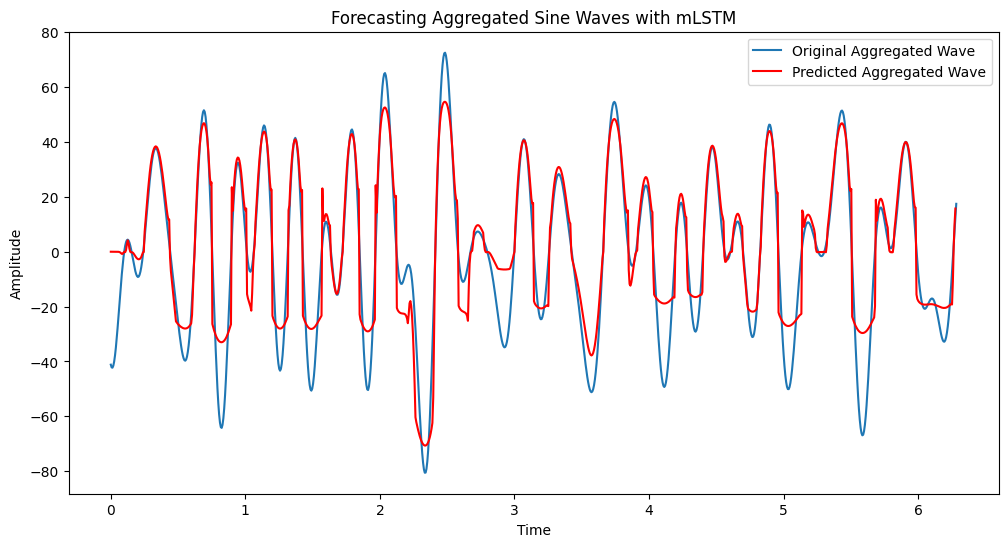

In [4]:
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt

# Function to generate individual sine waves
def generate_sine_wave(amplitude, frequency, phase, time):
    return amplitude * np.sin(2 * np.pi * frequency * time + phase)

# Generate aggregated sine wave
def generate_aggregated_wave(num_waves, time):
    aggregated_wave = np.zeros_like(time)
    for i in range(num_waves):
        amplitude = np.random.uniform(0.5, 2.0)  # Random amplitude between 0.5 and 2.0
        frequency = np.random.uniform(1, 5)     # Random frequency between 1 and 5 Hz
        phase = np.random.uniform(0, 2 * np.pi) # Random phase between 0 and 2*pi
        sine_wave = generate_sine_wave(amplitude, frequency, phase, time)
        aggregated_wave += sine_wave
    return aggregated_wave

# Define the mLSTM model
class mLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, mem_dim):
        super(mLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.mem_dim = mem_dim
        self.Wq = nn.Parameter(torch.randn(hidden_size, input_size))
        self.bq = nn.Parameter(torch.randn(hidden_size, 1))
        self.Wk = nn.Parameter(torch.randn(mem_dim, input_size))
        self.bk = nn.Parameter(torch.randn(mem_dim, 1))
        self.Wv = nn.Parameter(torch.randn(mem_dim, input_size))
        self.bv = nn.Parameter(torch.randn(mem_dim, 1))
        self.wi = nn.Parameter(torch.randn(1, input_size))
        self.bi = nn.Parameter(torch.randn(1))
        self.wf = nn.Parameter(torch.randn(1, input_size))
        self.bf = nn.Parameter(torch.randn(1))
        self.Wo = nn.Parameter(torch.randn(hidden_size, input_size))
        self.bo = nn.Parameter(torch.randn(hidden_size, 1))
        self.reset_parameters()

    def reset_parameters(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def forward(self, x, states):
        (C_prev, n_prev) = states
        qt = torch.matmul(self.Wq, x) + self.bq
        kt = (1 / math.sqrt(self.mem_dim)) * (torch.matmul(self.Wk, x) + self.bk)
        vt = torch.matmul(self.Wv, x) + self.bv

        it = torch.exp(torch.matmul(self.wi, x) + self.bi)
        ft = torch.sigmoid(torch.matmul(self.wf, x) + self.bf)

        vt = vt.squeeze()
        kt = kt.squeeze()

        C = ft * C_prev + it * torch.ger(vt, kt)
        n = ft * n_prev + it * kt.unsqueeze(1)

        max_nqt = torch.max(torch.abs(torch.matmul(n.T, qt)), torch.tensor(1.0))
        h_tilde = torch.matmul(C, qt) / max_nqt
        ot = torch.sigmoid(torch.matmul(self.Wo, x) + self.bo)
        ht = ot * h_tilde

        return ht, (C, n)

    def init_hidden(self):
        return (torch.zeros(self.mem_dim, self.mem_dim),
                torch.zeros(self.mem_dim, 1))

# Hyperparameters
input_size = 1
hidden_size = 10
mem_dim = 10
seq_len = 1000
num_waves = 1000

# Generate aggregated sine wave data
time = np.linspace(0, 2 * np.pi, seq_len)
aggregated_wave = generate_aggregated_wave(num_waves, time)
data = torch.tensor(aggregated_wave).float().view(1, -1, 1)

# Initialize the model, optimizer, and loss function
model = mLSTM(input_size, hidden_size, mem_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training the mLSTM
for epoch in range(500):
    states = model.init_hidden()
    optimizer.zero_grad()
    loss = 0
    for t in range(seq_len - 1):
        x = data[:, t]
        y_true = data[:, t + 1]
        y_pred, states = model(x, states)
        loss += criterion(y_pred, y_true)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss {loss.item()}')

# Testing the model
test_output = []
states = model.init_hidden()
for t in range(seq_len - 1):
    x = data[:, t]
    y_pred, states = model(x, states)
    test_output.append(y_pred.detach().numpy().ravel()[0])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time, aggregated_wave, label='Original Aggregated Wave')
plt.plot(time[:-1], test_output, label='Predicted Aggregated Wave', color='red')
plt.legend()
plt.title('Forecasting Aggregated Sine Waves with mLSTM')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()
